# Convolutional Neural Networks

## Project: Chest X-Ray Classification (Pneumonia vs Normal) 

---

### Instructions
For better understanding in this notebook some template code is already provided, and you will need to implement some additional functionalities to successfully complete this project.

> **Note for Implementation:** Sections that have **'IMPLEMENTATION'** heading, indicates that the following block needs implementations. Instructions details are provided for each implementation block and `To-DO` statments are also provided in the code cell. Before Starting to implement the functionality please read the instrcutions carefully and Pleaase do not modify or remove the template code!

---
### Project Description 

In this notebook, you will be implememnting a Convolutional Neural Network (CNN) model. You will go through different stages of data pre-processing and you will explore different methods by which we can implement a CNN model. 

The notebook is divided into following parts:

* Section 1: Import Dataset
* Section 2: Data Analysis & Pre-processing
* Section 3: Data Augumentation
* Section 4: Develop a CNN to Classify Chest X-Ray (from Scratch)
* Section 5: Develop a CNN to Classify Chest X-Ray (using Transfer Learning)
* Section 6: Comparison of CNN Models
* Section 7: Testing the best CNN Model

---
## Section 1: Import Dataset

### Chest X-Ray Dataset

For this project, we will be using [Chest X-Ray Images Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). This dataset consists of `5,863` X-Ray images and provides two classes of images (Normal and Pneumonia).

In the cells below, first we have imported the important libraries that will be useful throughout the notebook, we also have some constant variables like `DATASET_PATH, and IMG_CLASSES`. 

We also have a function `load_sample_imgs` which is used to load a sample training data, by which we can visualize the sample images for each class.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive')

In [3]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.12.0


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downloaded Dataset Path (in google drive)
DATASET_PATH = "/content/drive/MyDrive/chest_xray/Data"
IMG_CLASSES = ['NORMAL', 'PNEUMONIA']

def load_sample_imgs(path):
    imgs = []
    for cls in IMG_CLASSES:
        dir_path = os.path.join(path, cls)
        img_name = os.listdir(dir_path)[0]
        img = cv2.imread(os.path.join(dir_path, img_name))
        cls_index = IMG_CLASSES.index(cls)
        imgs.append([img, cls_index])
    
    return imgs

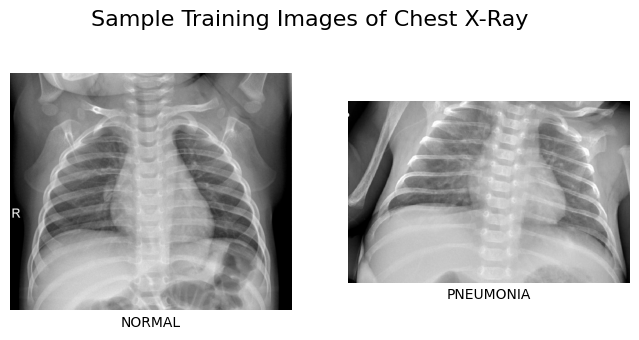

In [5]:
sample_imgs = load_sample_imgs(os.path.join(DATASET_PATH, 'train'))
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

plt.suptitle('Sample Training Images of Chest X-Ray', fontsize=16, y=0.95)

for index in range(2):
    img, cls_index = sample_imgs[index]
    ax[index].imshow(img)
    ax[index].set_xticks([])             
    ax[index].set_yticks([])
    ax[index].set_xlabel(IMG_CLASSES[cls_index])
    ax[index].spines['top'].set_visible(False)
    ax[index].spines['right'].set_visible(False)        
    ax[index].spines['left'].set_visible(False)                
    ax[index].spines['bottom'].set_visible(False)                

plt.show()

In the figure above, we can see the visualization of sample training images for each class.

> **Note:** While loading the sample image data, we have loaded the data in format [image, cls_index]. This is one of the many approaches by which we can load the complete dataset in a structured manner.

### IMPLEMENTATION

While visualizing the sample images, we can see that both images are not of same size, it means in the dataset all the images are of not same size. In the cell below you can see a constant variable **IMG_SIZE**, this varaible will be used throughout the notebook and will represent the size of images in the dataset. **Do a research and choose an appropriate Image Size for the images.**

Now we will load the whole dataset. We know that the dataset is divided into three different subsets: `Training, Validation and Testing`. **So in the code cell below you will need to complete the implementation of the function which will be used to load the dataset for given path, and while loading the dataset resize the images according to the Image size that you have selected**. 

> **Note:** Use the same data loading structure that have been used while loading the sample data.

In [61]:
img_size = 224
def load_data(data_dir):
    data = [] 
    for label in IMG_CLASSES: 
        path = os.path.join(data_dir, label)
        class_num = IMG_CLASSES.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Now after developing the data loading function, we will read the `Training` and `Validation` datasets. For now we will not going to load the `Testing` dataset because it will be used in the end to test the CNN models.

In [62]:
train_data = load_data(os.path.join(DATASET_PATH, 'train'))
#valid_data = load_data(os.path.join(DATASET_PATH, 'val'))

# print number of images in each dataset
print(f'There are {len(train_data)} Training Images.')
#print(f'There are {len(valid_data)} Validation Images.')

There are 4684 Training Images.


<ipython-input-61-39a53c9ed100>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


We can see that we don't have a good amount of data for validation set, so now we need to combine both datasets, then split into training and testing sets. 


### IMPLEMENTATION
**In the cell below, first combine both sets, then split into training and validation sets. (80% for Training, 20% for Validation)**

In [63]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

# print number of images in each dataset
print(f'There are {len(train_data)} Training Images.')
print(f'There are {len(valid_data)} Validation Images.')

There are 3747 Training Images.
There are 937 Validation Images.


In [64]:
X_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])

X_valid = np.array([x[0] for x in valid_data])
y_valid = np.array([x[1] for x in valid_data])


---
## Section 2: Data Pre-processing

Before starting to train the Deep Learning model we need to setup the dataset for best possible results. In our case as we are working with images the first thing to note is the size of all the images in the dataset and then we can move forward with all other techniques.

In our case as we have already setup the constant value for the size of all the images in the dataset so we don't need to worry about the size of the images in the dataset. Now we have multiple other steps that we need to take, first we will going to split the features and labels from the dataset that we have prepared early.

### Implementation
In the function below provide the code to split the features and labels into their seperate lists and then return the numpy arrays for each one of them.

Now as the function is ready to be used, so we will going to use the function to split features and labels from the dataset. First we will going to call the function for training dataset and then for validation dataset.

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{number_of_samples}, \text{image_height}, \text{image_width}, \text{channels}),
$$

where `number_of_samples` corresponds to the total number of images (or samples), and `image_height`, `image_width`, and `channels` correspond to the each image height, width, and channels.

By the running the cell below, we can check the tensor size of our training and validation data. First we will going to check the size of features and then we will move with labels/classes. 

In [69]:
print(f'Training Features Tensor Shape: {X_train.shape}')
print(f'Validation Features Tensor Shape: {X_valid.shape}')
print('\n')
print(f'Training Labels Tensor Shape: {y_train.shape}')
print(f'Validation Labels Tensor Shape: {y_valid.shape}')

Training Features Tensor Shape: (3747, 224, 224, 1)
Validation Features Tensor Shape: (937, 224, 224, 1)


Training Labels Tensor Shape: (3747, 2)
Validation Labels Tensor Shape: (937, 2)


### IMPLEMENTATION
For training and validation labels, we can see that we have tensors of shape `(200,)` and `(16,)`, which means we have a 1-D tensor. This is a binary dataset, which means we just have 2 classes in the dataset. For the better performance of the model we can use `One-Hot-Encoding` technique to One Hot Encode the labels, this is not a necessary step while working with Binary Classification data, but this is a cruicial step for Multi-Class Classification and that is why we also need to learn this step.

In the cell below you can implement the functionality to One-Hot Encode the labels of the dataset.

In [66]:
from keras.utils import to_categorical

# One-hot encoding for training and validation labels
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)


Now after implementing the `One-Hot Encoding` functionality we can again check the shape of the labels.

In [67]:
print(f'Training Labels Tensor Shape: {y_train.shape}')
print(f'Validation Labels Tensor Shape: {y_valid.shape}')

Training Labels Tensor Shape: (3747, 2)
Validation Labels Tensor Shape: (937, 2)


Now we have setup the features and labels of the dataset, let's explore the data a bit more and let us visualize the channels of the images. We know that the data is in `3 Channels` which means that the images in the dataset are having `Reg, Blue and Green` color channel which is also known as `RGB`. By running the cell below, we can visualize the image in each color channel. 

In [68]:
X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)

---
## Section 3: Data Augumentation

Data augmentation is a technique used in machine learning to artificially increase the size and diversity of a dataset by generating new data from existing data. Data augmentation provides improvement in the performance of machine learning models by exposing them to a wider range of variations in the data. Data augmentation is commonly used in computer vision applications such as image classification, object detection, and segmentation. 

For data augumentation we can make use of multiple techniques like Flipping, Rotation, Scaling, Cropping, Translation, Adding Noise to the image, etc. 

### IMPLEMENTATION
For Data Augumentation we will be using `ImageDataGenerator` function provided by `keras` library. In the cell below you have boilerplate code for the initialization of ImageDataGenerator object, while initializing the object, we need to pass in arguments which Augumentation techniques we need to use. 

**In the code below, we already have two arguments (Augumentation Techniques), you need to provide at least 2 more arguments to Augument the data, you can provide more as you want.** 

In [80]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

Now after initializing the data augumentation object, we need to use this object to visualize the dataset. 

In the cell below, we will use one single sample image and generate the augumented images. The generator object will augument the sample image and generate different samples of the images by the help of the techniques which we have provided. 

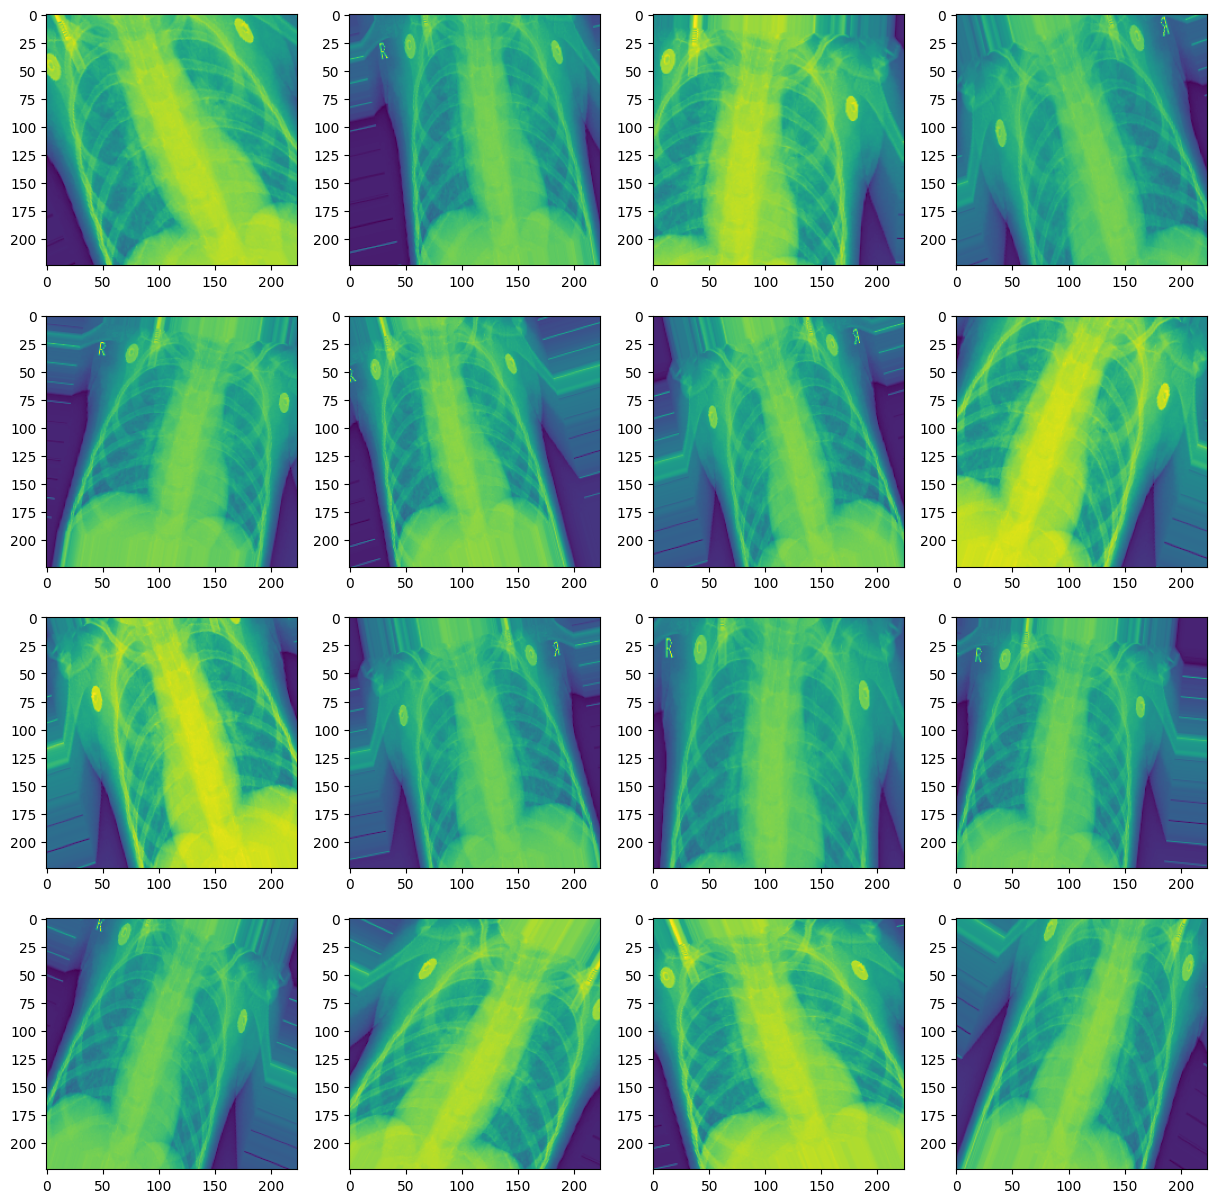

In [81]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

temp_batch = datagen.flow(X_train[:1], batch_size=1)

index = 0
for i in range(4):
    for j in range(4):
        img = next(temp_batch)[0]
        axes[i, j].imshow(img[:,:,0])
        index = index +1

---
## Section 4: Develop a CNN to Classify Chest X-Ray (from Scratch)

We have completed the Data pre-processing part, now it is the time to start developing the Convolutional Neural Network model. For this project we will be going to work with keras and Tensorflow library to develop and train the CNN model. CNN models have multiple layers that we can use, some of the standard layers that we need to use while working with CNN models are `Convolutinal Layer, Pooling Layer, Dropout Layer, Flatten Layer and Dense Layer`.

### IMPLEMENTATION
Now in the cell below we will going to define our model architecture. You have been given a boiler plate code with 1 Convolutional Layer and Output Layer of the model. 

**By using the boilerplate code develop a Convolutional Model architecutre. You need to use Conv2D, Pooling, Dropout and Dense Layers, etc. Please don't change anything in the boilerplate code.**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

# Building CNN model
# Initializing the Model
cnn_model = Sequential()

# Depth of Conv Layer(filters) will increase with each conv2D layer and by the help of pooling layer 
# the dimensionality will decrease and also it will prevent overfitting.
# Conv Layer
cnn_model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu",\
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)))
# Pooling layer
cnn_model.add(MaxPooling2D(pool_size=2))


# TODO: Develop a CNN Model architecutre, in this section add Conv, Pooling and Dropout layers.

# Hint: Consider adding a pooling layer before flattening the CNN outputs so that number of params in dense layer is not too much.
# Now adding a Flatten layer to flatten the matrix into a vector so then we can classify the data
cnn_model.add(Flatten())

# TODO: In this provide some Dense Layers before the output layer.
# Hint: Do not use too many units in dense layer (you may find that colab's memory limit reaches if you use too many params)

# Output Layer of the Model
cnn_model.add(Dense(2, activation="softmax"))

# Model Summary
cnn_model.summary()

The output of the above cell shows the summary of the CNN model. With the help of the model summary, we can see the trainable parameters, the complexity of the model, we can also check the output data shape for each layer. This is a good way to check the complexity of the model. 

Now we need to compile the model. While compiling the model we need to provide `loss function`, `optimizer`, and `metrics` which will be used during the training process of the Deep Learning model. There are many different choices of loss functions and optimizers which are avilable and we need to choose the best for our use case. 

### IMPLEMENTATION
In the cell below, **you need to provide the LOSS function and Optimization Function for the CNN Model**.

- [Available Loss Functions](https://keras.io/api/losses/probabilistic_losses/)
- [Available Optimization Functions](https://keras.io/api/optimizers/)

In [ ]:
#TODO: Provide Loss and Optimizer functions
cnn_model.compile(loss=None, optimizer=None, metrics=["accuracy"])

### IMPLEMENTATION

Now in the cell below we will be going to train our Convolutional Neural Network Model. For the training of the CNN model, **you need to provide a `Batch size` and `Number of Epochs`**. And after that you can run this cell to start the training process of the model.

In [ ]:
#TODO: You need to provide the Number of Epochs and Batch Size
Epochs = None
BATCH_SIZE = None

cnn_model_history = cnn_model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),\
                                validation_data=(x_valid, y_valid), epochs=Epochs,\
                                verbose=1, shuffle=True)

#### Evaluating the Trained Model
After training the Model, it is a good paractice to evaluate the model on Training Dataset to get the final Training Accuracy and Loss of the Model. By running the cell below you will be able to find out the training accuracy and loss of the CNN model. 

In [ ]:
training_score = cnn_model.evaluate(x_train, y_train)

print("\nTraining Accuracy:", round((training_score[1] * 100), 3),"%")
print("Training Loss:", training_score[0])

---
## Section 5: Develop a CNN to Classify Chest X-Ray (using Transfer Learning)

Now in this section we will be using pre-trained CNN model and train it using Transfer Learning Techniques. Transfer learning is a powerfull technique by which we can make use of complex and large pre-trained models and improve those models on our datasets. We have many different pre-trained CNN models available, you can access the list of all pre-trainned models in Keras Document, [link to pre-trained models](https://keras.io/api/applications/). 

There are different types of Transfer Learning techniques available, for this project we will be using `Fine Tuning` approach. Fine-tuning in transfer learning is a technique which is used to adapt a pre-trained model to a new dataset. This involves taking a pre-trained model that has been trained on a large dataset, and then improving it for a different dataset. The idea is that the model has already learned some general features and patterns from the original dataset, and these can be useful for the new dataset.

### IMPLEMENTATION

The First step to implement the Fine Tuning approach is to initialize a pre-trained model. **From the list of all available pre-trained models, choose a model according to your choice and initialize it in the cell given below**.

In [ ]:
# TODO: Initialize a pre-trained model
pretrained_model = None

# We don't need to train the pre-trained model we just need to fine-tune it
for layer in pretrained_model.layers:
        layer.trainable=False
# Note that setting layer.trainable = True will train model from scratch. 
# In this case, only the architechure will be the same as your pretrained models

Now in the second step of Fine Tuning, we need to add some `Dense` layers to the model. As you can see in the cell above, we have explicitly turned off the training of all the layers inside the pre-trainned model because we don't want the pre-trained model to be trained we just want to add some layers at the end of the model and then we will going to train those layers.

### IMPLEMENTATION
In the cell below, you have given a boilerplate code, the loaded pre-trained model has been attached to the CNN architecture and also the output layer of the model is initialized. **You need to add some more Dense, Dropout Layers in the CNN model architecture**.

In [ ]:
transfer_model = Sequential()     
transfer_model.add(pretrained_model)
transfer_model.add(Flatten())
# Hint: Add a pooling layer to reduce the input size to dense layer.

#TODO: Add some Dense, Dropout Layers

# Hint: Keep your size of Dense layer small (i.e. number of units in the dense layers. You may find colab crashing if you have too many params.)
# Output Layer of the Model
transfer_model.add(Dense(2, activation='softmax'))
transfer_model.summary()

In the Model Summary we can see that, the total number of parameters are much more higher than the trainable parameters. This is the best part of fine-tuning a CNN model, because we will use a pre-trained model and adapt it on our dataset even if we have less resources to train a large complex model.

Now we need to compile the model. While compiling the model we need to provide `loss function`, `optimizer`, and `metrics` which will be used during the training process of the Deep Learning model. There are many different choices of loss functions and optimizers which are avilable and we need to choose the best for our use case. 

### IMPLEMENTATION
In the cell below, **you need to provide the LOSS function and Optimization Function for the CNN Model**.

- [Available Loss Functions](https://keras.io/api/losses/probabilistic_losses/)
- [Available Optimization Functions](https://keras.io/api/optimizers/)

In [ ]:
#TODO: Provide Loss and Optimizer functions
transfer_model.compile(optimizer=None, loss=None, metrics=['accuracy'])

### IMPLEMENTATION

Now in the cell below we will be going to train the Convolutional Neural Network Model. As we have trained the CNN model previously, it will going to be the same steps. **Provide the code for training the CNN Model, and train the model on same number of Epochs as the previous CNN model**.

In [ ]:
#TODO: You need to provide the Batch Size, Number of Epochs will be the same as before
BATCH_SIZE = None

transfer_model_history = transfer_model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),\
                                            validation_data=(x_valid, y_valid), epochs=Epochs,\
                                            verbose=1, shuffle=True)

#### Evaluating the Trained Model
After training the Model, it is a good paractice to evaluate the model on Training Dataset to get the final Training Accuracy and Loss of the Model. By running the cell below you will be able to find out the training accuracy and loss of the CNN model which is trained by transfer learning. 

In [ ]:
transfer_model_score = transfer_model.evaluate(x_train, y_train)

print("\nTraining Accuracy:", round((transfer_model_score[1] * 100), 3),"%")
print("Training Loss:", transfer_model_score[0])

---
## Section 6: Comparison of CNN Models

### Visualizing Model Loss And Accuracy

We have successfully trained both CNN models and now it's time to compare the accuracy and loss of both models to know which one is the best one. While training the models, we can see that we have used **cnn_model_history variable** and **transfer_model_history variable**, these variable are used to store the accuracy and loss of the model for all Epochs. These variable holds the data in the form of python dictionary.

### IMPLEMENTATION
**By using the `cnn_model_history` and `transfer_model_history` variables and matplotlib library plot the Accuracy and Loss graphs of the models. You need to plot Accuracy and Loss graphs having Training and Validation data for both models.**

In [ ]:
#TODO: Plot the Accuracy Graph

In [ ]:
#TODO: Plot the Loss Graph

---
## Section 7: Testing the best CNN Model

Now in this last section of the Notebook, we will test the best CNN model.

#### IMPLEMENTATION
**Load the testing set in the cell below.**

In [ ]:
# TODO: Load the Testing Dataset
test_data = None

# print number of images in testing dataset
print(f'There are {len(test_data)} Testing Images.')

### IMPLEMENTATION
**Split the Features and Labels of the Testing Set.**

In [ ]:
# TODO: Split the Features and Labels of Testing Data
x_test, y_test = None

print(f'Testing Features Tensor Shape: {x_test.shape}')

We have loaded and setup the testing dataset, now it's time to use the best model and make the prediction for testing images.

In [ ]:
predictions = transfer_model.predict(x_test)
prediction_labels = np.argmax(predictions, axis=1)

### Confusion Matrix
A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions made by the model compared to the actual outcomes. The matrix is usually presented as a square table, with the rows representing the actual class labels and the columns representing the predicted class labels. The confusion matrix provides several useful metrics for evaluating the performance of a classification model, such as accuracy, precision, recall, and F1 score. 

### IMPLEMENTATION
We have original labels and predicted labels, now you need to use **scikit-learn** and **matplotlib** lilbrary to plot the confusion matrix.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#TODO: Compute and Plot the Confusion matrix for testing data

### Classification Report

A classification report is a summary of the key performance metrics for a classification model. The classification report includes several important metrics, including precision, recall, F1 score, and support. These metrics provide information about the model's ability to correctly identify positive and negative instances, as well as the balance between precision and recall.

Please run the cell below to generate the classification report for the Best Performing CNN Model.

In [ ]:
print(classification_report(y_test, prediction_labels))

---
## Conclusion

In the Notebook, we have learned how we can develop Convolutional Neural Network Models. We have learned how we can develop our own CNN architectures and how we can make use of Transfer Learning Techniques. We have gone through the data preperation part, model development part and finally we have evaluated and tested the CNN Models. 